In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [6]:
import os

zip_path = "/content/drive/MyDrive/data-science-bowl-2018.zip"
print("Exists:", os.path.exists(zip_path))


Exists: True


In [7]:
import zipfile, os

zip_path = "/content/drive/MyDrive/data-science-bowl-2018.zip"
extract_path = "/content/data-science-bowl-2018"

if not os.path.exists(extract_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)

print("Extracted:", os.listdir(extract_path)[:5])


Extracted: ['stage1_sample_submission.csv.zip', 'stage1_solution.csv.zip', 'stage1_test.zip', 'stage2_test_final.zip', 'stage2_sample_submission_final.csv.zip']


In [9]:
import os, zipfile

base_path = "/content/data-science-bowl-2018"

# unzip stage1_train and stage1_test
for fname in ["stage1_train.zip", "stage1_test.zip"]:
    fpath = os.path.join(base_path, fname)
    out_dir = os.path.join(base_path, fname.replace(".zip", ""))

    if not os.path.exists(out_dir):
        with zipfile.ZipFile(fpath, 'r') as z:
            z.extractall(out_dir)

print("Folders now:", os.listdir(base_path))


Folders now: ['stage1_train', 'stage1_sample_submission.csv.zip', 'stage1_solution.csv.zip', 'stage1_test.zip', 'stage2_test_final.zip', 'stage2_sample_submission_final.csv.zip', 'stage1_test', 'stage1_train.zip', 'stage1_train_labels.csv.zip']


In [10]:
DATASET_PATH = "/content/data-science-bowl-2018"

TRAIN_PATH = os.path.join(DATASET_PATH, "stage1_train")
TEST_PATH  = os.path.join(DATASET_PATH, "stage1_test")

print("Train images:", len(os.listdir(TRAIN_PATH)))


Train images: 670


In [18]:

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
# skimage utilities for segmentation and labeling

from skimage import io, measure, morphology

from scipy import ndimage as ndi
from skimage.segmentation import watershed


plt.rcParams["figure.figsize"] = (6,6) # Set default figure size for plots



(np.float64(-0.5), np.float64(255.5), np.float64(255.5), np.float64(-0.5))

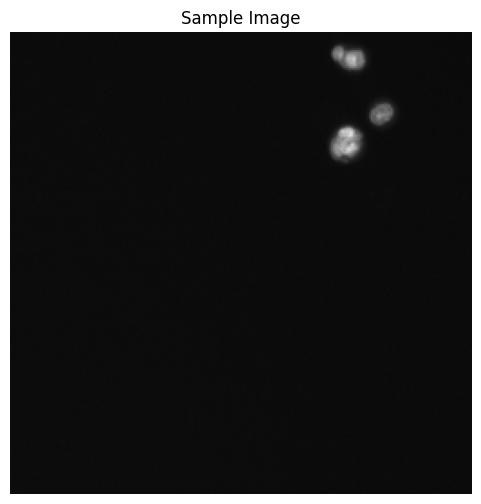

In [19]:
    # Load RGB microscopy image and merge all nucleus masks into one binary mask
def load_image_and_mask(image_id):
    img_dir = os.path.join(TRAIN_PATH, image_id, "images")
    mask_dir = os.path.join(TRAIN_PATH, image_id, "masks")

    img_file = os.listdir(img_dir)[0]
    image = io.imread(os.path.join(img_dir, img_file))

    mask = np.zeros(image.shape[:2], dtype=np.uint8)
    for m in os.listdir(mask_dir):
        m_img = io.imread(os.path.join(mask_dir, m))
        mask = np.maximum(mask, m_img)

    return image, mask

# pick sample
sample_id = os.listdir(TRAIN_PATH)[0]
image, gt_mask = load_image_and_mask(sample_id)

plt.imshow(image)
plt.title("Sample Image")
plt.axis("off")


In [23]:
def watershed_without_markers(image):     # Perform standard watershed segmentation using automatically detected distance peaks

    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    _, thresh = cv2.threshold(
        gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU
    )

    dist = cv2.distanceTransform(thresh, cv2.DIST_L2, 5)

    markers = measure.label(dist > 0.3 * dist.max())
    labels = watershed(-dist, markers, mask=thresh)

    return labels


In [24]:
def watershed_with_markers(image):     # Perform marker-controlled watershed using foreground seeds from distance transform

    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    _, thresh = cv2.threshold(
        gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU
    )

    kernel = np.ones((3,3), np.uint8)
    opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, 2)

    sure_bg = cv2.dilate(opening, kernel, 3)

    dist = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
    _, sure_fg = cv2.threshold(dist, 0.4 * dist.max(), 255, 0)
    sure_fg = np.uint8(sure_fg)

    markers = measure.label(sure_fg)
    labels = watershed(-dist, markers, mask=thresh)

    return labels


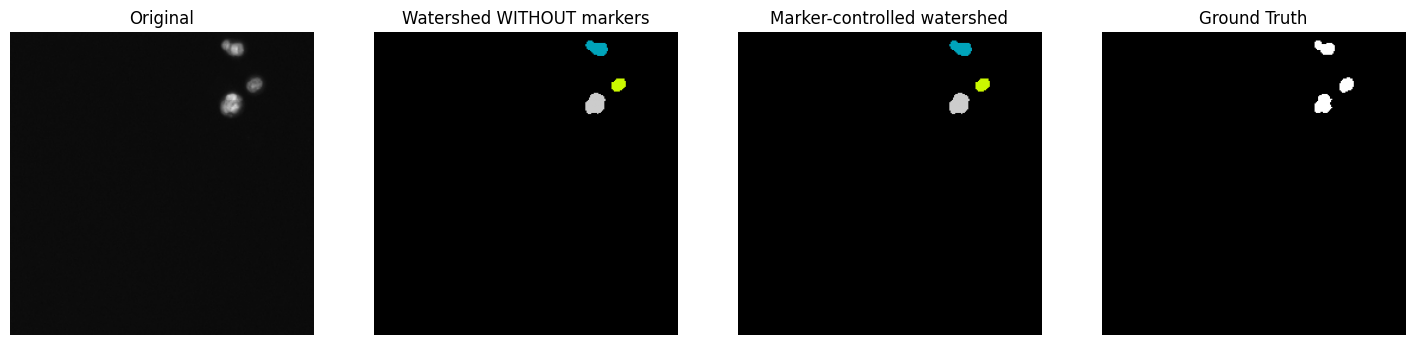

In [25]:
labels_no = watershed_without_markers(image)
labels_yes = watershed_with_markers(image)

fig, ax = plt.subplots(1,4, figsize=(18,5))

ax[0].imshow(image)
ax[0].set_title("Original")

ax[1].imshow(labels_no, cmap="nipy_spectral")
ax[1].set_title("Watershed WITHOUT markers")

ax[2].imshow(labels_yes, cmap="nipy_spectral")
ax[2].set_title("Marker-controlled watershed")

ax[3].imshow(gt_mask, cmap="gray")
ax[3].set_title("Ground Truth")

for a in ax:
    a.axis("off")


In [26]:
def count_objects(labels):
    return len(np.unique(labels)) - 1

print("Objects WITHOUT markers:", count_objects(labels_no))
print("Objects WITH markers:", count_objects(labels_yes))


Objects WITHOUT markers: 3
Objects WITH markers: 3


In [27]:
def dice_score(pred, gt):
    pred = pred > 0
    gt = gt > 0

    intersection = np.logical_and(pred, gt).sum()
    return 2 * intersection / (pred.sum() + gt.sum() + 1e-8)


In [28]:
dice_no = dice_score(labels_no, gt_mask)
dice_yes = dice_score(labels_yes, gt_mask)

print("Dice WITHOUT markers:", round(dice_no, 4))
print("Dice WITH markers:", round(dice_yes, 4))


Dice WITHOUT markers: 0.9057
Dice WITH markers: 0.9057


In [29]:
ids = os.listdir(TRAIN_PATH)[:10]

dice_no_list = []
dice_yes_list = []

for img_id in ids:
    img, gt = load_image_and_mask(img_id)

    l_no = watershed_without_markers(img)
    l_yes = watershed_with_markers(img)

    dice_no_list.append(dice_score(l_no, gt))
    dice_yes_list.append(dice_score(l_yes, gt))

print("Average Dice WITHOUT markers:", np.mean(dice_no_list))
print("Average Dice WITH markers:", np.mean(dice_yes_list))


Average Dice WITHOUT markers: 0.9403540729475315
Average Dice WITH markers: 0.9401668154939783


# **Conclusion:**

1) In this experiment, both standard watershed and marker-controlled watershed were able to segment the nuclei correctly and showed high Dice scores (around 0.94), which means the detected regions matched well with the ground truth masks. Since the selected images contained mostly well-separated nuclei, both methods produced similar segmentation results and object counts.

2) Marker-controlled watershed is generally more reliable for nuclei separation because it uses defined seed points for each nucleus, which helps avoid over-segmentation when nuclei are touching or clustered.